# Resources

This is a library of classes and functions which I often employ in simulations and numerical work. The classes (and occasional function) are organized alphabetically by titled section (within each section, the classes themselves are organized by importance/inheritance, as needed).


In [5]:
# Import required Python libraries
from __future__ import division     # In Python 3.x this will not be needed.
import math
import numpy as np
from warnings import warn
import scipy.stats as stats
from scipy.integrate import quad
from numpy.random import RandomState
from scipy.interpolate import interp1d
import pylab as plt

from numpy import log, exp # For ease of reading in get_improved_grid

In [6]:
import numba as nb
from numba import jit, njit, float64, int64, boolean
from numba.typed import List
from numba.experimental import jitclass

## Jittable frozen distribution of log normal 

In [7]:
MeanOneLogNormalPara=[
    ('sigma', float64),   
    ('mu',float64),
    ('sim_N', int64),             
    ('sim_draws', float64[:]),
    ('X',float64[:]),
    ('pmf',float64[:]),
    ('approx_N',int64)
]

@jitclass(MeanOneLogNormalPara)
class MeanOneLogNormal:
    def __init__(self,
                 sigma = 0.40,
                 sim_N = 100000,
                 approx_N = 7):

        self.sigma = sigma ## underlying normal std
        self.sim_N = sim_N
        self.mu = -sigma**2/2 ## underlying normal mean
        self.sim_draws = np.random.lognormal(-sigma**2/2 , 
                                             sigma,
                                             sim_N)
        self.approx_N = approx_N
        self.discretize()
        
    def pdf(self,
           x):
        lx = np.log(x)
        ## notice there is a x in denominator 
        return 1/(self.sigma * x*np.sqrt(2 * np.pi)) *np.exp(- (lx - self.mu)**2 / (2 * self.sigma**2))
    
    def cdf(self,
           x):
        ## cdf 
        sim_draws_sort = np.sort(self.sim_draws)
        cdf = np.sum(sim_draws_sort<=x)/self.sim_N
        return cdf
    
    def invcdf(self,
              cdf):
        sim_draws_sort = np.sort(self.sim_draws)
        if cdf >0.0 and cdf <1.0:
            cdfs = 1.0 * np.arange(self.sim_N)/self.sim_N 
            where_idx = np.min(cdfs<=cdf)
            where_idx = np.searchsorted(cdfs,cdf) ## the location index of the cdf
            if where_idx==0:
                left_x = sim_draws_sort[where_idx]
            elif where_idx==self.sim_N:
                left_x = sim_draws_sort[where_idx-1]
            else:
                left_x, right_x = sim_draws_sort[where_idx-1],sim_draws_sort[where_idx]
            x = (left_x+right_x)/2
        elif cdf ==0.0:
            x = np.min(sim_draws_sort)
        else:
            x = np.max(sim_draws_sort)
        return x 
        
    def discretize(self):
        """
        N equally probable values of the random variable
        """
        N = self.approx_N
        probs_cutoffs = np.arange(N+1)/N        # Includes 0 and 1
        state_cutoffs = np.array([self.invcdf(prob_cutoff) for prob_cutoff in probs_cutoffs]) # State cutoff values, each bin
        bin_probs = np.empty(N,float64)
        
        # Find the E[X|bin] values:
        #F = lambda x: x*self.pdf(x)
        Ebins = np.empty(N,float64)
        
        for i, (x0, x1) in enumerate(zip(state_cutoffs[:-1], state_cutoffs[1:])):
            bin_probs[i] = self.cdf(x1) - self.cdf(x0) ## pdf between x0 and x1 
            cond_mean = self.integrate_by_sum(x0, x1)
            #cond_mean, err = quad(F, x0, x1)
            Ebins[i]=cond_mean/bin_probs[i] 

        self.X = Ebins
        self.pmf = bin_probs
        #return self.X,self.pmf

    def integrate_by_sum(self,
                         x0,
                         x1,
                         bins = 10000,
                         how ='midpoint'):
        """
        integrate pdfs by sum over very finely divided bins between x0 and x1. 
        it is an good approximation as long as the number of bins is fine enough
        the pdf is calculated exactly 
        """
        dx = (x1-x0)/bins
        xs = np.linspace(x0,x1,bins)
        if how == 'left':
            x_left = xs[:-1]
            to_sum = np.array([self.pdf(x)*x for x in x_left])*dx
            return np.sum(to_sum)
        elif how == 'right':
            x_right = xs[1:]
            to_sum = np.array([self.pdf(x)*x for x in x_right])*dx
            return np.sum(to_sum)
        elif how == 'midpoint':
            x_mid = (xs[:-1] + xs[1:])/2
            to_sum = np.array([self.pdf(x)*x for x in x_mid])*dx
            return np.sum(to_sum)
        else:
            raise ValueError("Method must be 'left', 'right' or 'midpoint'.")

[0.63883529 0.89392654 0.93960275 0.97700978 1.01276725 1.05261243
 1.10628252 1.50272673]
[0.84508737 0.90809876 0.9677552  0.99316105 1.03303602 1.07267172
 1.17933932]


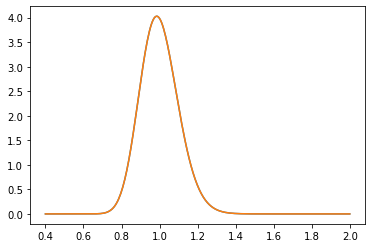

In [17]:
if __name__ == "__main__":
    
    sigma = 0.1
    N = 7

    # new model 
    ln = MeanOneLogNormal(sigma=sigma)
    # scipy 
    ln_sp = stats.lognorm(s= ln.sigma, scale = np.exp(ln.mu))


    ## compare pdf is computed right compared to scipy 

    Xs = np.linspace(0.4,2.0,300)

    ln_pdf = np.array([ln.pdf(x) for x in Xs])
    sp_pdf = ln_sp.pdf(Xs)

    ## plot pdfs 
    plt.plot(Xs,ln_pdf)
    plt.plot(Xs,sp_pdf)

    ### discretization 
    print(ln.X)

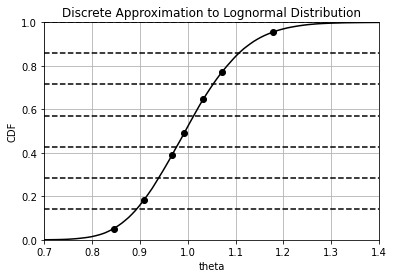

In [18]:
def plot(ln, x0, x1, gridsize=100):
    """
    Plot the discrete approximation against the actual distribution.
    """
    grid = np.linspace(x0, x1, gridsize)        

    plt.plot(ln.X, np.array([ln.cdf(x) for x in ln.X]), 'ok')
    plt.plot(grid, np.array([ln.cdf(x) for x in grid]), 'k-')
    plt.axis([x0, x1, 0, 1])
    plt.hlines(ln.pmf.cumsum(),x0, x1,color ="black",linestyles='--') ## added by Tao to show equiprobable ranges
    plt.title('Discrete Approximation to Lognormal Distribution')
    plt.xlabel('theta')
    plt.ylabel('CDF')
    plt.grid()
    plt.show()
    
    
if __name__ == "__main__":
    plot(ln,0.7,1.4)

## Discrete Approximation to a Continuous Distribution

This implements a Python version of the discrete approximation code used in Carroll's Microeconomic DSOP notes. 

In [19]:
class DiscreteApproximation(object):
        
    def __init__(self, 
                 N, 
                 cdf, 
                 pdf, 
                 invcdf, 
                 precise_summation=False):
        """
        Given a cdf, pdf, and invererse cdf, and number of evenly-spaced bins
        (a partition) of a state space, find the conditional expected values 
        of each evenly-sized partition,  E[X|partition]
        
        An equidistant grid is imposed upon the [0,1] range, and the inverse cdf 
        is employed to determine the appropriate "bin cutoffs." 
                
        The cdf, pdf, and inverse cdf need to be "frozen" distributions -- they 
        need to have their parameters already set and only accept one value to 
        produce output.  

        Note that the MATLAB version has a manually-entered minpoint and maxpoint. 
        These numbers, used "raw" as an upper bound in the Fortran QUADPACK 
        automatic integration function (which is used by both Numpy and Octave, 
        as well as many others) cause numerical instability in the solution. 
        
        The solution is to use np.inf as the upper bound, which happens 
        automatically when the state cutoffs are determined. The np.inf values
        forces correct evaluation of the integral.
        For more details please see discussion in this stackoverflow:
        http://stackoverflow.com/questions/24003694/discontinuity-in-results-when-using-scipy-integrate-quad
        """
        self.cdf = cdf
        self.pdf = pdf
        self.invcdf = invcdf
        self.N = N      # Number of bins
        probs_cutoffs = np.arange(N+1)/N        # Includes 0 and 1
        state_cutoffs = invcdf(probs_cutoffs)   # State cutoff values, each bin
        #bin_probs = np.diff(probs_cutoffs)      # Total prob mass, each bin
        bin_probs = np.zeros(N)
    
        # Find the E[X|bin] values:
        F = lambda x: x*self.pdf(x)
        Ebins = []
        for i, (x0, x1) in enumerate(zip(state_cutoffs[:-1], state_cutoffs[1:])):
            bin_probs[i] = cdf(x1) - cdf(x0) ## pdf between x0 and x1 
            cond_mean, err = quad(F, x0, x1)
            Ebins.append(cond_mean/bin_probs[i])

        self.X = np.array(Ebins)
        self.pmf = bin_probs

        self.precise_summation = precise_summation
        

    def E(self, f=None):
        """
        Find expectation of f(X) over the discrete space.
        """
        if f is None:
            if self.precise_summation:
                return math.fsum(self.pmf * self.X)  # High precision
            else:
                return self.pmf.dot(self.X)          # ~100x faster
        else:
            if self.precise_summation:
                return math.fsum(np.multiply(self.pmf, f(self.X))) # High precision
            else:
                return self.pmf.dot(f(self.X))                     # ~100x faster


    def plot(self, x0, x1, gridsize=100):
        """
        Plot the discrete approximation against the actual distribution.
        """
        grid = np.linspace(x0, x1, gridsize)        
        
        plt.plot(self.X, self.cdf(self.X), 'ok')
        plt.plot(grid, self.cdf(grid), 'k-')
        plt.axis([x0, x1, 0, 1])
        plt.hlines(self.pmf.cumsum(),x0, x1,color ="black",linestyles='--') ## added by Tao to show equiprobable ranges
        plt.title('Discrete Approximation to Lognormal Distribution')
        plt.xlabel('theta')
        plt.ylabel('CDF')
        plt.grid()
        plt.show()

## A Specific Discrete Approximation to the Mean-one lognormal:

Now we use simple inheritance to create a mean-one lognormal instance quickly and easily.

In [20]:
class DiscreteApproximationToMeanOneLogNormal(DiscreteApproximation):
    """
    Extension of the DiscreteApproximation class, which creates a mean-one 
    lognormal approximation, given standard deviation 'sigma' and number 
    of grid-points 'N'.
    """
    
    def __init__(self, N, sigma, precise_summation=False):
        """
        Given N and sigma, create a lognormal "frozen" distribution object,
        and initilize an appropriate DiscreteApproximation.
                
        N:      integer, number of grid points to interpolate over
        sigma:  double, standard deviation of the lognormal distribution
        """
        
        # Save the one bit of new information (N saved in super()):
        self.sigma = sigma
        self.mu = -0.5*(self.sigma**2) 

        # Set up the "frozen" lognormal:
        distrib = stats.lognorm(self.sigma, 0, np.exp(self.mu)) 
        
        # Create the class:
        super(DiscreteApproximationToMeanOneLogNormal, self).__init__(
                N, distrib.cdf, distrib.pdf, distrib.ppf,
                precise_summation=precise_summation)
        
        # Everything is done now. 


LNDiscApprox.E():1.0
Success: Unconditional expectation is correct!
Success: Eg(X) = manually calculated values.
All tests passed successfully.


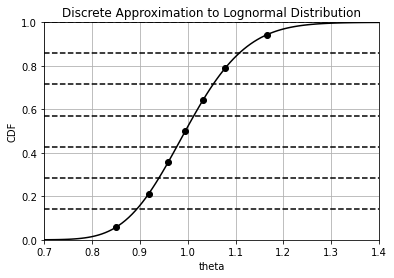

In [21]:
# Testing:
if __name__ == "__main__":
    import numpy as np
    import pylab as plt
    from warnings import warn
    from scipy.integrate import quad
    from numpy.random import RandomState
    from scipy.interpolate import interp1d
    import scipy.stats as stats
    from copy import deepcopy

    # Create a 2-D discrete approximation instance:
    sigma = sigma
    N = N
    
    LNDiscApprox = DiscreteApproximationToMeanOneLogNormal(N, sigma)
    
    print("LNDiscApprox.E():"+ str(LNDiscApprox.E()))
    # Check that "raw expectation" is correct:
    assert np.max(np.abs(LNDiscApprox.E() - 1.0)) < 1e-16, "Unconditional expectation is not correct!"
    print("Success: Unconditional expectation is correct!")
    
    # Check that the expectation applied to a misc function is correct:
    # Manually, the 7-point approximation for each gridpoint should be:
    manual_X = np.array([ 0.85043016002691718125,  0.91862318529875575113,
        0.95908470592906813756,  0.99506598629571241243,
        1.03241349447674446438,  1.0779763032188010019 ,
        1.16640616475400205054])
    manual_p = np.repeat(1.0/N, N)

    # Check for a random function: 
    g = lambda x1: x1**2 + 1.5
    
    # Manually construct the expectation of g:
    manual_EgX = 0.0
    for x, p in zip(manual_X, manual_p):
        manual_EgX += g(x) * p
            
    # Now compare manual value against vectorized:
    EgX = LNDiscApprox.E(g)
      
    #print "manual_EgXY:", manual_EgXY
    #print "EgXY:", EgXY
    
    assert np.abs(manual_EgX - EgX) < 1e-12,"Eg(X) not equal between the values that have expectations."
    print("Success: Eg(X) = manually calculated values.")
    print("All tests passed successfully.")
    
    LNDiscApprox.plot(0.7, 1.4)
    
    # Comparing to the 0630 Matlab definition:
    matsig = np.array([0.509520331925153, 0.667826497278589, 0.776380649071803, 0.879396570886877, 0.989752424342583, 1.121403448305962, 1.305157824866014, 1.750562243647017])
    matN   = 8

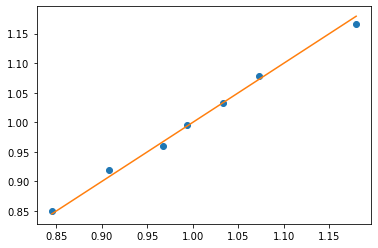

In [22]:
if __name__ == "__main__":
    plt.plot(ln.X,LNDiscApprox.X,'o')
    plt.plot(ln.X,ln.X)